In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("EDA").config("hive.metastore.uris", "thrift://amok:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session

#spark.sql("USE 2023_04_01")





SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-04-11 17:13:23,340 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-04-11 17:13:24,401 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2024-04-11 17:13:26,345 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental f

In [2]:
spark.sql("USE 2023_11_02")

DataFrame[]

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import col, to_date, lit, udf, pandas_udf, PandasUDFType, coalesce, \
            month, year, concat, date_format, format_string, last_day, months_between, greatest, least, when, lag, count, desc, expr, log1p
from pyspark.sql.window import Window
from datetime import timedelta
from pyspark.sql.types import*
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import csv
import math
#import pyspark.pandas as ps
import seaborn as sns

/opt/jupyterhub/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [4]:
from pipelines.CreateDataset import get_fund_data

In [5]:
import os

curr_dir = os.getcwd()
main_dir = os.path.dirname(curr_dir)
print(main_dir)

/home/ztewari


In [6]:
def get_all_tickers():
    query = f"""SELECT s.ticker_region, s.fsym_id
                FROM sym_ticker_region s 
                LEFT JOIN FF_SEC_COVERAGE c ON c.fsym_id = s.fsym_id
                LEFT JOIN sym_coverage sc ON sc.fsym_id = s.fsym_id
                INNER JOIN fp_basic_prices p ON p.fsym_id = sc.fsym_regional_id
                WHERE s.ticker_region LIKE "%-US" AND s.ticker_region NOT LIKE '%.%' AND c.CURRENCY = "USD" 
                AND (sc.fref_listing_exchange = "NAS" OR sc.fref_listing_exchange = "NYS") AND p.p_date >= '2000-01-01'
                ORDER BY s.fsym_id"""
    


    adj = spark.sql(query)
    return adj


def get_full_df(fn):
    all_tickers_df = pd.read_csv(f'data/{fn}', index_col=False)
    # all_tickers_df = all_tickers_df[:1000]
    fsym_id_df = spark.createDataFrame(all_tickers_df[['fsym_id']].astype(str))
    price_df = get_fund_data(fsym_id_df)
    price_df = price_df.toPandas()
    return price_df

# full_df = get_full_df('imploded_stocks_price.csv')

In [7]:
# for fsym_id, group in full_df.groupby('fsym_id'):
#     group['return'] = group['adj_price'].pct_change()
#     group['cum_return'] = (1 + group['return']).cumprod() - 1
#     full_df.loc[group.index, ['return', 'cum_return']] = group[['return', 'cum_return']]

In [8]:
# full_df.dropna(inplace=True)
# full_df.head()

In [9]:
def find_implosion_price(df1, price_drop_thresh=-0.6, period_thresh=78, increase_thresh=-0.1):
    df1 = df1.reset_index()
    max_price = df1['adj_price'].max()
    # df['EMA'] = df['adj_price'].ewm(span=n, min_periods=n, adjust=False).mean()
    if max_price < 100:
        return []
    df1 = df1.sort_values(by='date')
    i = 26 #lookback
    imp_dates = []
    while i < len(df1):
        current_date = df1.loc[i, 'date']
        current_cum = df1.loc[i, 'cum_return']
        current_price = df1.loc[i, 'adj_price']
        if df1.loc[i, 'cum_return'] < price_drop_thresh:
            imp_dates.append((current_date, df1.loc[i, 'date']))
            j = i
            start_price=current_price
            j+=1
            imp_period=0
            while j < len(df1) and (df1.loc[j, 'adj_price'] - start_price)/start_price  <= increase_thresh:
                imp_period+=1
                j+=1
            if imp_period > period_thresh:
                imp_dates.append((current_date, df1.loc[i+imp_period, 'date']))
            i+=imp_period
        i+=1
    return imp_dates

def find_implosion_price3(df1, price_drop_thresh=-0.6, period_thresh=78, increase_thresh=-0.1):
    df1 = df1.reset_index()
    max_price = df1['adj_price'].max()
    df1['rolling_mean'] = df1['adj_price'].rolling(window=52).mean()
    # df['EMA'] = df['adj_price'].ewm(span=n, min_periods=n, adjust=False).mean()
    if max_price < 100:
        return []
    df1 = df1.sort_values(by='date')
    i = 52 #lookback
    imp_dates = []
    while i < len(df1):
        current_date = df1.loc[i, 'date']
        current_price = df1.loc[i, 'adj_price']
        mean_price = df1.loc[i, 'rolling_mean']
        if (current_price - mean_price)/current_price < price_drop_thresh:
            imp_dates.append((current_date, df1.loc[i, 'date']))
            j = i
            start_price=current_price
            j+=1
            imp_period=0
            while j < len(df1) and (df1.loc[j, 'adj_price'] - start_price)/start_price  <= increase_thresh:
                imp_period+=1
                j+=1
            if imp_period > period_thresh:
                imp_dates.append((current_date, df1.loc[i+imp_period, 'date']))
            i+=imp_period
        i+=1
    return imp_dates

def find_implosion_price2(df1, price_drop_thresh=-0.6, period_thresh=78, increase_thresh=0.1):
    df1 = df1.reset_index()
    max_price = df1['adj_price'].max()
    # df['EMA'] = df['adj_price'].ewm(span=n, min_periods=n, adjust=False).mean()
    if max_price < 100:
        return []
    df1 = df1.sort_values(by='date')
    i = 26 #lookback
    lookback = i
    imp_dates = []
    while i < len(df1):
        if i <= 52:
            lookback = i
        current_date = df1.loc[i, 'date']
        current_price = df1.loc[i, 'adj_price']
        avg_return = df1.loc[i-lookback:i, 'return'].mean()
        std_return = df1.loc[i-lookback:i, 'return'].std()
        current_return = df1.loc[i, 'return']
        
        if current_return < (avg_return - (3.09 * std_return)):
            # imp_dates.append((current_date, df1.loc[i+1, 'date']))
            j = i+26
            lookback2 = 26
            start_price=current_price
            imp_period=0
            while j < len(df1):
                if (df1.loc[j,'adj_price'] - df1.loc[j-lookback2,'adj_price'])/df1.loc[j-lookback2,'adj_price'] > increase_thresh:
                    break
                imp_period+=1
                j+=1
            if imp_period > period_thresh:
                imp_dates.append((current_date, df1.loc[i+imp_period, 'date']))
            i+=imp_period
        i+=1
    return imp_dates
    
#     if len(imp_dates)>0:
#         df1.loc[df1['fsym_id']==fsym_id, 'Implosion_Start_Date'] = imp_dates[0][0]
#         df1.loc[df1['fsym_id']==fsym_id, 'Implosion_End_Date'] = imp_dates[0][1]
#         df1.loc[df1['fsym_id']==fsym_id, 'Num_Implosions'] = len(imp_dates)

#     return df1

imp_count = 0


# for fsym_id, group in full_df.groupby('fsym_id'):
#     imp_dates = find_implosion_price3(group)
#     imp_dates2 = find_implosion_price(group)
#     if imp_dates or imp_dates2:
#         fig, axs = plt.subplots(1, 2, figsize=(10, 4))
#     if imp_dates:
#         imp_count+=1
#         axs[0].plot(group['date'], group['adj_price'], label=fsym_id)
#         for i in imp_dates:
#             axs[0].axvspan(i[0], i[1], alpha=0.5, color='blue')
#         axs[0].legend()
    
#     if imp_dates2:
#         imp_count+=1
#         axs[1].plot(group['date'], group['adj_price'], label=fsym_id)
#         for i in imp_dates2:
#             axs[1].axvspan(i[0], i[1], alpha=0.5, color='blue')
#         axs[1].legend()
        
#     if imp_dates or imp_dates2:
#         plt.tight_layout()
#         plt.show()
    

In [10]:
imp_count

0

In [7]:

df = pd.read_csv('data/imploded_stocks_price.csv', index_col=False)
print(len(df))
df = df[df['Implosion_Start_Date'].notnull()]
print(len(df))

10826
712


In [30]:
def get_imploded_tickers(df):
    stock_df = pd.read_csv(f'data/imploded_stocks_price.csv')
    stock_df = stock_df.loc[stock_df['Implosion_Start_Date'].notnull()]
    stock_df = spark.createDataFrame(stock_df)
    stock_df.createOrReplaceTempView("temp_table")

    
    
#     df['fsym_id'] = df['fsym_id'].astype(str)
#     df = df['fsym_id']

#     spark_df = spark.createDataFrame(df)
#     spark_df.createOrReplaceTempView("temp_table")
    query = f"""SELECT s.ticker_region, t.fsym_id
                FROM temp_table t
                INNER JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN FF_SEC_COVERAGE c ON c.fsym_id = s.fsym_id
                LEFT JOIN sym_coverage sc ON sc.fsym_id = s.fsym_id
                ORDER BY t.fsym_id"""
    


    adj = spark.sql(query)
    adj.show(10)
    return adj

tickers_df = get_imploded_tickers(df)    

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


+-------------+--------+
|ticker_region| fsym_id|
+-------------+--------+
|      BSFC-US|B06303-R|
|      WISA-US|B0CXCV-R|
|        PT-US|B0P5YF-R|
|      AMEH-US|B15GK7-R|
|      ASKJ-US|B18QS9-R|
|      PRTK-US|B1CVR7-R|
|      SGLY-US|B2FJ50-R|
|      SNOA-US|B2JT9Z-R|
|      CEMI-US|B3DNJ5-R|
|      XPEL-US|B3HL2X-R|
+-------------+--------+
only showing top 10 rows



In [31]:
tickers_df.filter(col('ticker_region') == 'ACOR-US').show()

+-------------+--------+
|ticker_region| fsym_id|
+-------------+--------+
|      ACOR-US|VBKMCH-R|
+-------------+--------+



/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


Number with no industry label:  0


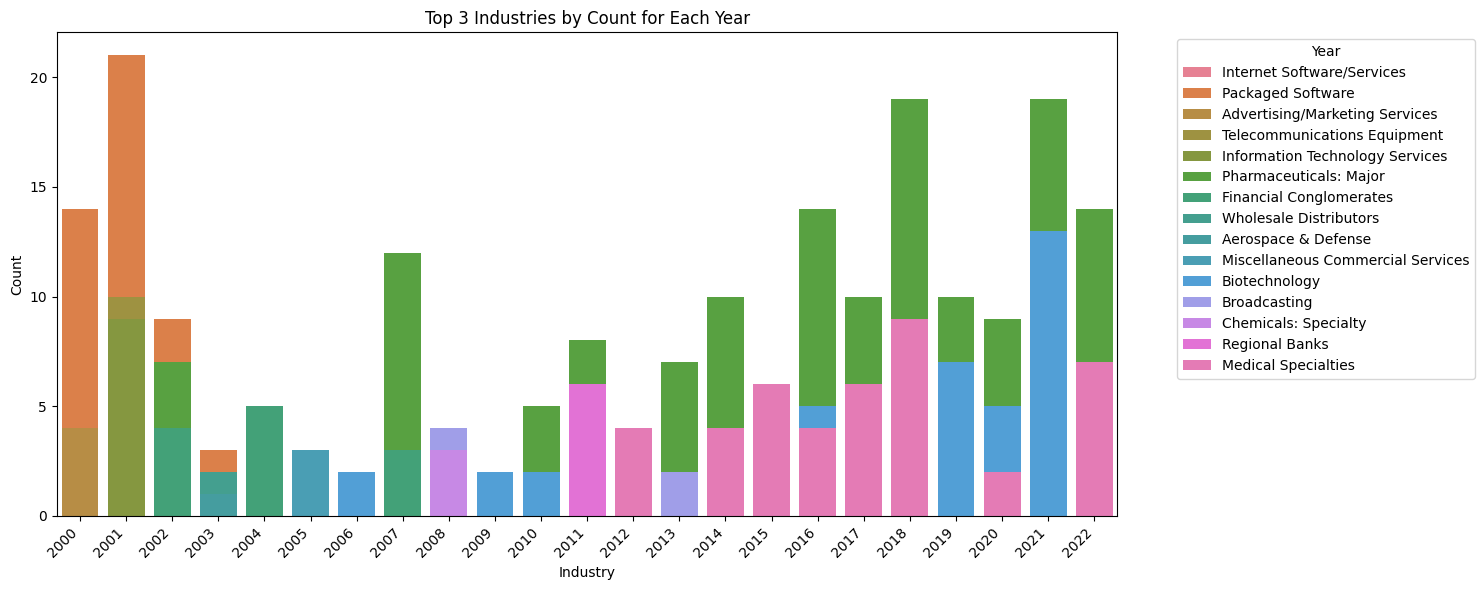

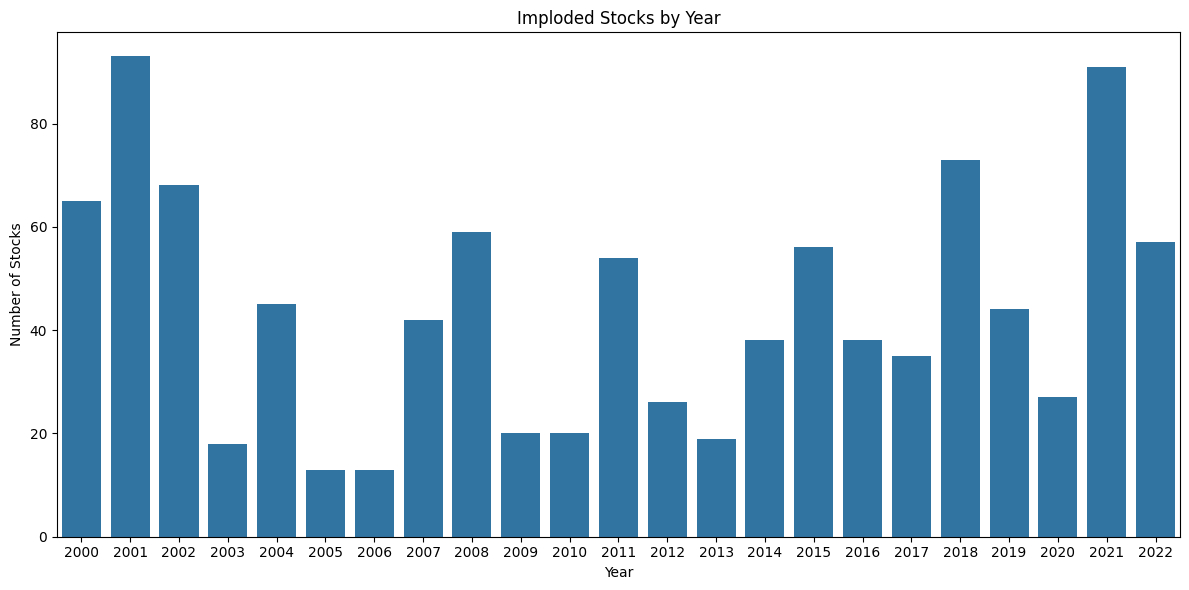

In [16]:
def industry_analysis_implosions(fn):
    stock_df = pd.read_csv(f'data/{fn}')
    stock_df = stock_df.loc[stock_df['Implosion_Start_Date'].notnull()]
    stock_df = spark.createDataFrame(stock_df)
    stock_df.createOrReplaceTempView("temp_table")
    q2 = """SELECT t.fsym_id, t.Implosion_Start_Date, e.factset_industry_desc FROM temp_table t
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    ORDER BY t.fsym_id
    """
    ind_df = spark.sql(q2)
    ind_df = ind_df.toPandas()
    ind_df['Implosion_Date'] = pd.to_datetime(ind_df['Implosion_Start_Date'])
    ind_df['year'] = ind_df['Implosion_Date'].dt.year
    null_count = ind_df['factset_industry_desc'].isnull().sum()
    print("Number with no industry label: ", null_count)
    
    ind_df_grp = ind_df.groupby(['year', 'factset_industry_desc']).size().reset_index(name='count')
    ind_df_grp = ind_df_grp.sort_values(by=['year', 'count'], ascending=[True, False])

    # Group the sorted dataframe by year
    grouped = ind_df_grp.groupby('year')
    
    # Take the top 3 rows for each group
    ind_df_grp = grouped.head(3)
    ind_df_grp.reset_index(drop=True, inplace=True)
    
    max_count = ind_df_grp['count'].max()
    
    plt.figure(figsize=(15, 6))
    sns.barplot(x='year', y='count', hue='factset_industry_desc', data=ind_df_grp, dodge=False)

    plt.xlabel('Industry')
    plt.ylabel('Count')
    plt.title('Top 3 Industries by Count for Each Year')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.yticks(range(0, max_count + 1, 5))
    plt.tight_layout()
    plt.savefig(f'{fn}_by_industry.png')
    plt.show()

#     plt.figure(figsize=(12, 6))
#     sns.barplot(x='year', y='count', hue='factset_industry_desc', data=ind_df_grp)

#     plt.title('Imploded Stocks by Industry and Year')
#     plt.xlabel('Year')
#     plt.ylabel('Number of Stocks')
#     plt.legend(title='Industry', bbox_to_anchor=(1, 1), loc='upper left')
#     plt.tight_layout()

    
    ind_df_year = ind_df.groupby('year').size().reset_index(name='count')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='year', y='count', data=ind_df_year)

    plt.title('Imploded Stocks by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Stocks')
    plt.tight_layout()
    plt.savefig(f'{fn}_per_year.png')
    plt.show()
    
    
def industry_all(fn):
    stock_df = pd.read_csv(f'data/{fn}', usecols = ['fsym_id'])
    # stock_df = stock_df.loc[stock_df['Implosion_Start_Date'].notnull()]
    stock_df = spark.createDataFrame(stock_df)
    stock_df.createOrReplaceTempView("temp_table")
    q2 = """SELECT t.fsym_id, e.factset_industry_desc FROM temp_table t
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    ORDER BY t.fsym_id
    """
    ind_df = spark.sql(q2)
    ind_df = ind_df.toPandas()
    
    ind_df_grp = ind_df.groupby(['factset_industry_desc']).size().reset_index(name='count')

    ind_df_grp = ind_df_grp[ind_df_grp['count'] >= 175]

    plt.figure(figsize=(8, 8))  # Adjust figure size for pie chart

    # Create the pie chart
    plt.pie(ind_df_grp['count'], labels=ind_df_grp['factset_industry_desc'], autopct="%1.1f%%")

    # Customize the pie chart
    plt.title('Stocks by Industry Distribution')
    plt.axis('equal')  # Equal aspect ratio for a circular pie chart

    # Save the pie chart
    plt.tight_layout()
    plt.savefig('all_by_industry_pie.png')
    
industry_analysis_implosions('imploded_stocks_price.csv')

In [6]:
def plot_prices(imp_df, pic_name):
    adj = get_fund_data(imp_df)
    imp_df = imp_df.toPandas()
    adj_pd = adj.toPandas()
    adj_pd['date'] = pd.to_datetime(adj_pd['date'])
    list_to_plot = sorted(adj_pd['fsym_id'].unique().tolist())
    
    columns = 8
    num_rows = math.ceil(len(list_to_plot) / columns)
    fig, axs = plt.subplots(nrows=num_rows, ncols=columns, figsize=(35, 5*num_rows))
    axs = axs.flatten()
    
    i = 0
    for t in list_to_plot:
        temp_df = adj_pd[adj_pd['fsym_id']==t]
        axs[i].plot(temp_df['date'], temp_df['adj_price'], label=t)
        # axs[i].plot(temp_df['date'], temp_df['adj_price'].rolling(52).mean(), label=f'{t} (52-week)')
        # axs[i].plot(temp_df['date'], temp_df['adj_price'].rolling(5).mean(), label=f'{t} (5-week)')
        
        # axs[i].plot(temp_df['date'], temp_df['adj_price'].ewm(span=7, adjust=False).mean())
        # axs[i].plot(temp_df['date'], temp_df['adj_price'].ewm(span=52, adjust=False).mean())
        
        imp_start_date = imp_df.loc[imp_df['fsym_id']==t, 'Implosion_Start_Date'].iloc[0]
        imp_end_date = imp_df.loc[imp_df['fsym_id']==t, 'Implosion_End_Date'].iloc[0]
        if imp_start_date is not None:
            # filtered_temp_df = temp_df[(temp_df['p_date'] >= imp_start_date) & (temp_df['p_date'] <= imp_end_date)]
            # vol = filtered_temp_df['split_adj_price'].std()
            imp_start_date = pd.to_datetime(imp_start_date)
            imp_end_date = pd.to_datetime(imp_end_date)
            #filtered_temp_df = temp_df[(temp_df['p_date'] >= imp_start_date) & (temp_df['p_date'] <= imp_end_date)]
            #print(filtered_temp_df.head())
            axs[i].axvspan(imp_start_date, imp_end_date, alpha=0.5, color='blue')
        axs[i].legend()
        #axs[i].text(0.5, -0.1, f'Volatility: {vol:.2f}', ha='center', transform=axs[i].transAxes)
        i+=1
        
    for i in range(len(list_to_plot), num_rows * columns):
        fig.delaxes(axs.flatten()[i])
    
        
    plt.tight_layout()
    plt.savefig(pic_name)
    
    
def sample_plots():
    imp_df = pd.read_csv('imploded_stocks_dd.csv', index_col=False)
    imps_only = imp_df.loc[imp_df['Implosion_Start_Date'].notnull()]
    imps_only = spark.createDataFrame(imps_only.tail(24))
    plot_prices(imps_only, 'sample_implosions_dd.png')
    
def sample_plots_2022():
    imp_df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    imps_only = imp_df.loc[imp_df['Implosion_Start_Date'].notnull()]
    imps_only['Implosion_Start_Date'] = pd.to_datetime(imps_only['Implosion_Start_Date'])
    imps_only['year'] = imps_only['Implosion_Start_Date'].dt.year
    imps_only = imps_only[imps_only['year']==2022]
    imps_only = spark.createDataFrame(imps_only.tail(40))
    plot_prices(imps_only, 'sample_implosions_2022.png')
    compare_with_yahoo(imps_only)




def compare_with_yahoo(df):
    df.createOrReplaceTempView('temp')
    q = """SELECT str.ticker_region, t.fsym_id FROM temp t LEFT JOIN sym_ticker_region str ON str.fsym_id = t.fsym_id"""
    ticker_df = spark.sql(q)
    ticker_df = ticker_df.toPandas()
    list_to_plot = sorted(ticker_df['ticker_region'].tolist())
    
    columns = 3
    num_rows = math.ceil(len(list_to_plot) / columns)
    fig, axs = plt.subplots(nrows=num_rows, ncols=columns, figsize=(15, 5*num_rows))
    axs = axs.flatten()
    i=0
    for t in list_to_plot:
        stock_data = yf.download(t[:-3], start='2001-01-01', end='2023-11-02')
        if not stock_data.empty:
            stock_data = stock_data['Adj Close'].resample('W').last()
            axs[i].plot(stock_data.index, stock_data, label=ticker_df.loc[ticker_df['ticker_region'] == t, 'fsym_id'])
            axs[i].legend()
        i+=1
            
    for i in range(len(list_to_plot), num_rows * columns):
        fig.delaxes(axs.flatten()[i])
    plt.tight_layout()
    plt.savefig('yahoo_stocks.png')
    

# sample_plots()
# visualize_implosions()
# sample_plots_2022()

In [10]:
def industry_plots(industry):
    stock_df = pd.read_csv('data/imploded_stocks_price.csv')
    stock_df = stock_df.loc[stock_df['Implosion_Start_Date'].notnull()]
    stock_df = spark.createDataFrame(stock_df)
    stock_df.createOrReplaceTempView("temp_table")
    q2 = f"""SELECT t.fsym_id, t.Implosion_Start_Date, t.Implosion_End_Date, e.factset_industry_desc FROM temp_table t
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    WHERE e.factset_industry_desc = "{industry}"
    ORDER BY t.fsym_id
    """
    ind_df = spark.sql(q2)
    plot_prices(ind_df.limit(100), f"{industry}_imploded.png")
    
    
# industry_plots('Pharmaceuticals: Major')

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-02-16 00:54:48,200 ERROR scheduler.AsyncEventQueue: Listener EventLoggingListener threw an exception
java.util.ConcurrentModificationException
	at java.util.Hashtable$Enumerator.next(Hashtable.java:1408)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:424)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:420)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.mutable.MapLi

Number with no industry label:  1


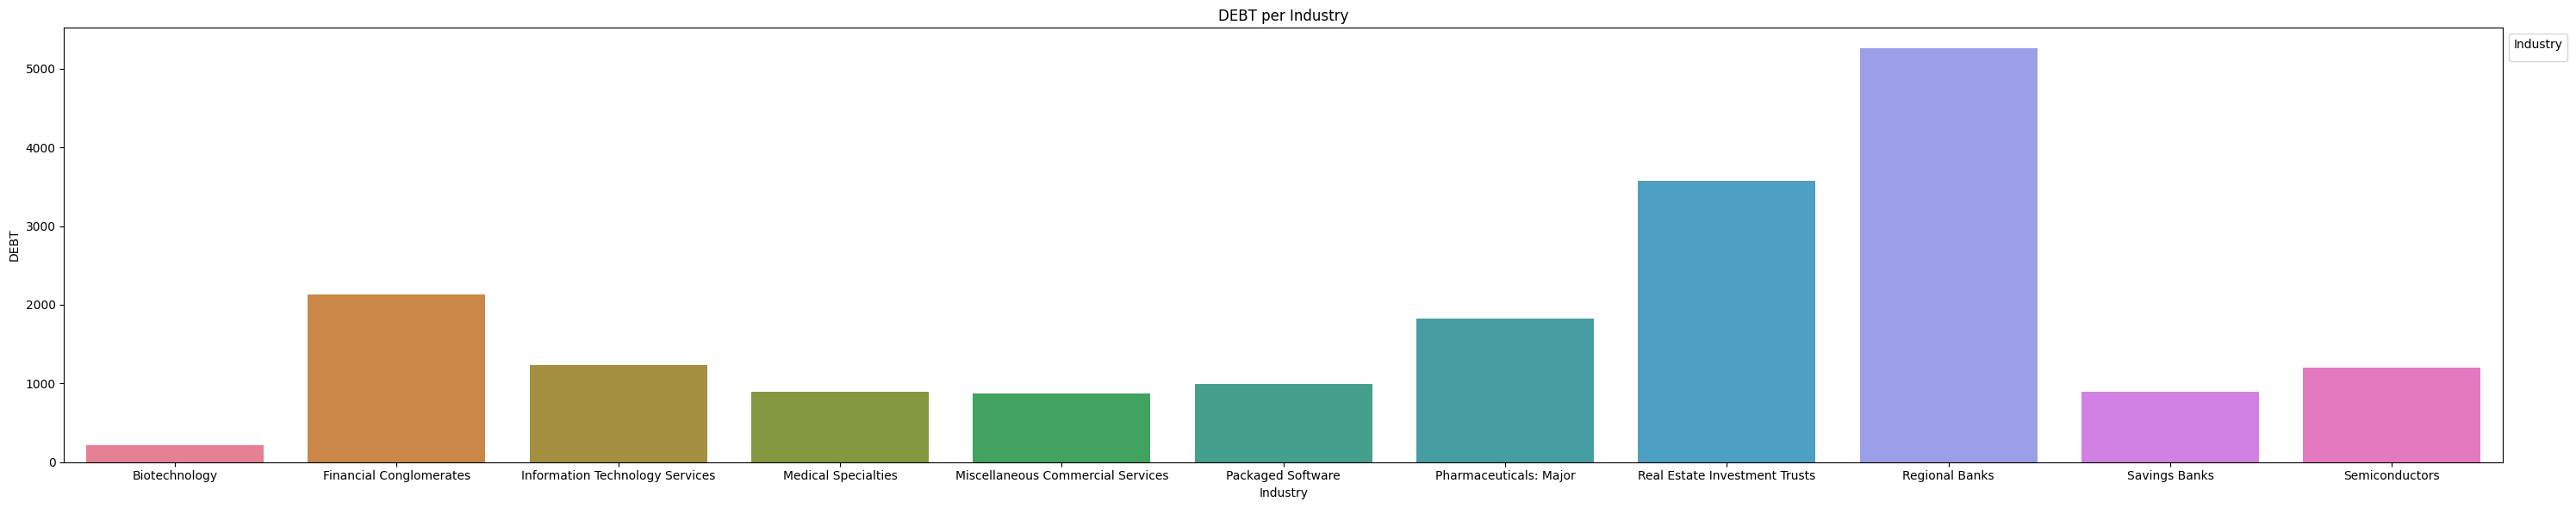

In [32]:
def industry_analysis_compare(fn, metric):
    stock_df = pd.read_csv(f'data/{fn}', usecols=['fsym_id'])
    stock_df = spark.createDataFrame(stock_df)
    stock_df.createOrReplaceTempView("temp_table")
    q2 = f"""SELECT e.factset_industry_desc AS industry, AVG({metric}) AS {metric[5:]}, COUNT(DISTINCT(t.fsym_id)) AS count FROM temp_table t
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    LEFT JOIN FF_ADVANCED_DER_QF a ON a.fsym_id = t.fsym_id
    LEFT JOIN FF_BASIC_DER_QF b ON b.fsym_id = t.fsym_id
    LEFT JOIN FF_BASIC_QF g ON g.fsym_id = t.fsym_id
    WHERE a.date > '2000-01-01' AND b.date > '2000-01-01' AND g.date > '2000-01-01'
    GROUP BY e.factset_industry_desc
    ORDER BY e.factset_industry_desc
    """
    ind_df = spark.sql(q2)
    ind_df = ind_df.toPandas()
    null_count = ind_df['industry'].isnull().sum()
    print("Number with no industry label: ", null_count)
    # ind_df = ind_df[ind_df['industry'].isin(['Pharmaceuticals: Major', 'Packaged Software', 'Telecommunications Equipment', 'Biotechnology', 'Internet Software/Services' ])]
    ind_df = ind_df[ind_df['count']>200]
    plt.figure(figsize=(30, 6))
    sns.barplot(x='industry', y=f'{metric[5:]}', hue='industry', data=ind_df)

    plt.title(f'{metric[5:]} per Industry')
    plt.xlabel('Industry')
    plt.ylabel(f'{metric[5:]}')
    plt.legend(title='Industry', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{metric[5:]}_by_industry.png')
    
industry_analysis_compare('imploded_stocks_price.csv', 'g.FF_DEBT')

In [36]:
def stock_start_analysis():
    stocks_df = pd.read_csv('imploded_stocks_price.csv')
    stocks_df['Implosion_Start_Date'] = pd.to_datetime(stocks_df['Implosion_Start_Date'])
    stocks_df['Implosion_End_Date'] = pd.to_datetime(stocks_df['Implosion_End_Date'])
    stocks_df = spark.createDataFrame(stocks_df)
    stocks_df.createOrReplaceTempView("temp_table")
    query = f"""SELECT t.fsym_id, c.p_first_date FROM temp_table t LEFT JOIN fp_sec_coverage c ON c.fsym_id=t.fsym_id
                    ORDER BY t.fsym_id
            """
    start_df = spark.sql(query)
    start_df = start_df.toPandas()
    start_df['p_first_date'] = pd.to_datetime(start_df['p_first_date'])
    start_df['Year'] = start_df['p_first_date'].dt.year
    print(start_df.head())
    starts_per_year = start_df.groupby('Year').size()
    print(starts_per_year)
    
    plt.figure(figsize=(10,5))
    starts_per_year.plot(kind='bar')
    plt.title('Earliest dates of stocks')
    plt.xlabel('Year')
    plt.ylabel('Number of Stocks')

    plt.show()
    


    
    
    
# stock_start_analysis()  
# compare_methods()
# compare_lengths()
#create_implosion_price_plots()

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/tmp/ipykernel_2786856/221574346.py:17: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q1 = data.quantile(0.25)
/tmp/ipykernel_2786856/221574346.py:18: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q3 = data.quantile(0.75)
/tmp/ipykernel_2786856/221574346.py:28: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)

697
9631


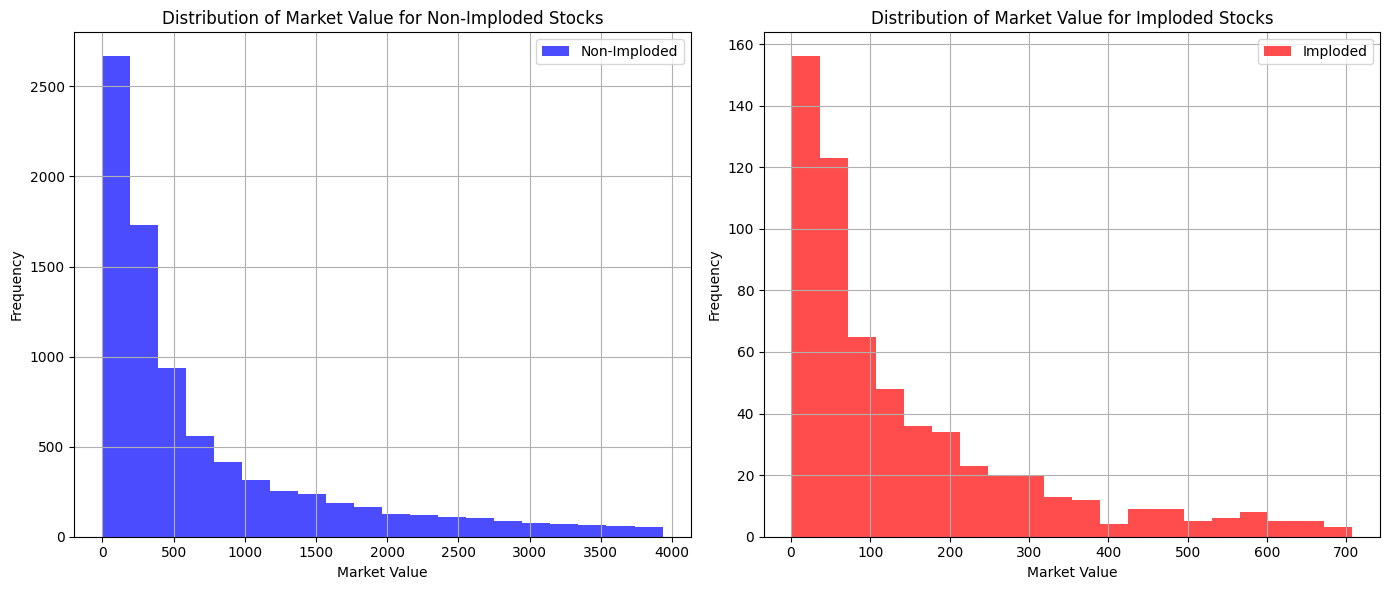

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

def classify_market_cap(market_value):
    if market_value < 50000000:  # Small cap threshold (adjust as needed)
        return 'Nano Cap'
    elif market_value < 2000000000:  # Medium cap threshold (adjust as needed)
        return 'Small Cap'
    elif market_value > 10000000000:  # Medium cap threshold (adjust as needed)
        return 'Large Cap'
    else:
        return 'Medium Cap'
    
    
def remove_outliers(data):
    # Calculate first and third quartile
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    
    # Interquartile range
    iqr = q3 - q1
    
    # Define the lower and upper bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Filter the data within the bounds
    return data[(data >= lower_bound) & (data <= upper_bound)]

def compare_mkt_val():
    df = pd.read_csv('data/imploded_stocks_price.csv')
    impl_df = df.loc[df['Implosion_Start_Date'].notnull()]
    non_impl_df = df.loc[df['Implosion_Start_Date'].isnull()]
    impl_df_spark = spark.createDataFrame(impl_df)
    non_impl_df_spark = spark.createDataFrame(non_impl_df)
    impl_df_spark.createOrReplaceTempView('imp')
    non_impl_df_spark.createOrReplaceTempView('non_imp')
    # Query to calculate average Z-scores for both imploded and non-imploded stocks
    impl_query = """
    SELECT i.fsym_id, MEAN(a.FF_MKT_VAL) AS mkt_val
    FROM imp i 
    INNER JOIN FF_BASIC_DER_AF a ON a.fsym_id = i.fsym_id
    GROUP BY i.fsym_id
    """
    non_impl_query = """
    SELECT n.fsym_id, MEAN(a.FF_MKT_VAL) AS mkt_val
    FROM non_imp n
    INNER JOIN FF_BASIC_DER_AF a ON a.fsym_id = n.fsym_id
    GROUP BY n.fsym_id
    """
    imp_market_value = spark.sql(impl_query).toPandas()
    non_imp_market_value= spark.sql(non_impl_query).toPandas()

    
    # Convert to Pandas DataFrame
    non_imp = non_imp_market_value
    imp = imp_market_value
    non_imp.dropna(inplace=True)
    imp.dropna(inplace=True)
    imp = remove_outliers(imp)
    non_imp = remove_outliers(non_imp)
    
    print(len(imp))
    print(len(non_imp))
    # Plot pie chart for non-imploded stocks
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot histogram for non-imploded stocks
    axs[0].hist(non_imp['mkt_val'], bins=20, color='blue', alpha=0.7, label='Non-Imploded')
    axs[0].set_title('Distribution of Market Value for Non-Imploded Stocks')
    axs[0].set_xlabel('Market Value')
    axs[0].set_ylabel('Frequency')
    axs[0].legend()
    axs[0].grid(True)
    
    # Plot histogram for imploded stocks
    axs[1].hist(imp['mkt_val'], bins=20, color='red', alpha=0.7, label='Imploded')
    axs[1].set_title('Distribution of Market Value for Imploded Stocks')
    axs[1].set_xlabel('Market Value')
    axs[1].set_ylabel('Frequency')
    axs[1].legend()
    axs[1].grid(True)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the image
    plt.savefig('market_value_distribution.png')
    
    # Show the plot
    plt.show()

# Call the function to execute
compare_mkt_val()



/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/tmp/ipykernel_2786856/2044792971.py:6: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q1 = data.quantile(0.25)
/tmp/ipykernel_2786856/2044792971.py:7: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q3 = data.quantile(0.75)
/tmp/ipykernel_2786856/2044792971.py:17: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False

  fsym_id  avg_z_score      Type
0     NaN     0.598937  Imploded
1     NaN     0.173886  Imploded
3     NaN     3.593352  Imploded
4     NaN   -26.661496  Imploded
5     NaN     0.529176  Imploded


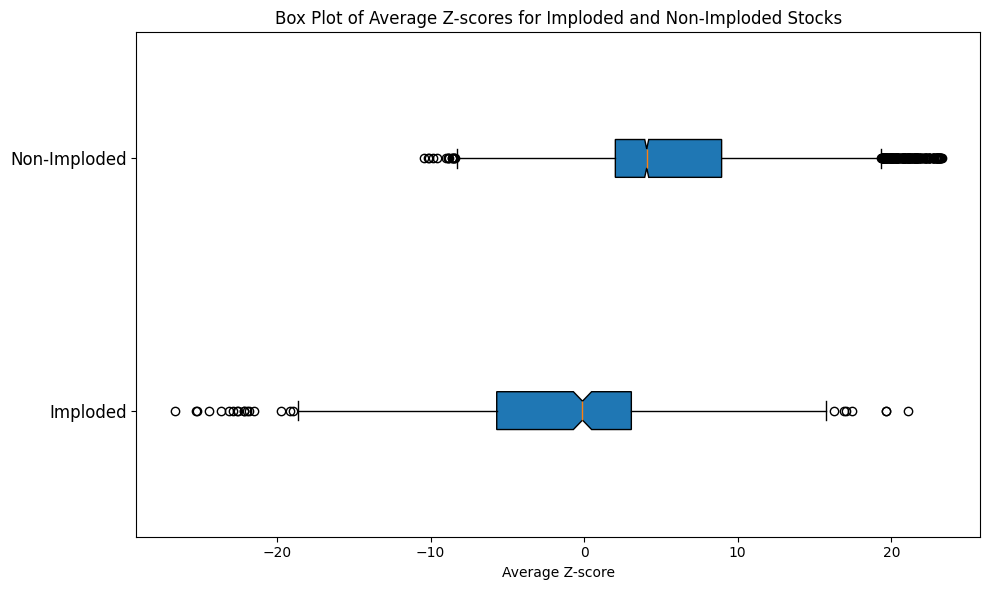

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

def remove_outliers(data):
    # Calculate first and third quartile
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    
    # Interquartile range
    iqr = q3 - q1
    
    # Define the lower and upper bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Filter the data within the bounds
    return data[(data >= lower_bound) & (data <= upper_bound)]

def compare_z_score():
    df = pd.read_csv('data/imploded_stocks_price.csv')
    impl_df = df.loc[df['Implosion_Start_Date'].notnull()]
    non_impl_df = df.loc[df['Implosion_Start_Date'].isnull()]
    impl_df_spark = spark.createDataFrame(impl_df)
    non_impl_df_spark = spark.createDataFrame(non_impl_df)
    impl_df_spark.createOrReplaceTempView('imp')
    non_impl_df_spark.createOrReplaceTempView('non_imp')
    
    # Query to calculate average Z-scores for both imploded and non-imploded stocks
    impl_query = """
    SELECT i.fsym_id, MEAN(a.FF_ZSCORE) AS avg_z_score 
    FROM imp i 
    INNER JOIN FF_ADVANCED_DER_QF a ON a.fsym_id = i.fsym_id
    GROUP BY i.fsym_id
    """
    non_impl_query = """
    SELECT n.fsym_id, MEAN(a.FF_ZSCORE) AS avg_z_score 
    FROM non_imp n
    INNER JOIN FF_ADVANCED_DER_QF a ON a.fsym_id = n.fsym_id
    GROUP BY n.fsym_id
    """
    impl_df = spark.sql(impl_query).toPandas()
    non_impl_df = spark.sql(non_impl_query).toPandas()
    impl_df = remove_outliers(impl_df)
    non_impl_df = remove_outliers(non_impl_df)
    
    # Add categorical column for plotting
    impl_df['Type'] = 'Imploded'
    non_impl_df['Type'] = 'Non-Imploded'
    
    # Merge the dataframes
    merged_df = pd.concat([impl_df, non_impl_df])
    merged_df = merged_df.dropna(subset=['avg_z_score'])
    print(merged_df.head())
    
    # Remove extreme outliers using Tukey's method
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.boxplot([merged_df[merged_df['Type'] == 'Imploded']['avg_z_score'], 
                 merged_df[merged_df['Type'] == 'Non-Imploded']['avg_z_score']],
                labels=['Imploded', 'Non-Imploded'], vert=False, notch=True, patch_artist=True)
    
    # Customizing appearance
    plt.title('Box Plot of Average Z-scores for Imploded and Non-Imploded Stocks')
    plt.xlabel('Average Z-score')
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('Z_score_comparison.png')

# Call the function to execute
compare_z_score()


In [12]:
def zscore_plots():
    stock_df = pd.read_csv('imploded_stocks_price.csv')
    stock_df = stock_df.loc[stock_df['Implosion_Start_Date'].notnull()]
    stock_df = spark.createDataFrame(stock_df)
    stock_series = get_fund_data(stock_df)
    stock_series = stock_series.join(stock_df.select("fsym_id", "Implosion_Start_Date"), "fsym_id", "inner")
    stock_series.createOrReplaceTempView('temp')
    q =f"""SELECT t.fsym_id, t.date, t.Implosion_Start_Date, t.adj_price, a.FF_ZSCORE FROM temp t LEFT JOIN FF_ADVANCED_DER_QF a ON YEAR(a.date) = YEAR(t.date)
                AND MONTH(t.date) = MONTH(a.date) AND t.fsym_id = a.fsym_id"""
    z_df = spark.sql(q)
    z_df = z_df.orderBy('fsym_id', 'date')

    
#     # Convert 'p_date' to datetime if needed
    z_df = z_df.toPandas()
    z_df['date'] = pd.to_datetime(z_df['date'])
    z_df['FF_ZSCORE'] = z_df['FF_ZSCORE'].fillna(method='ffill')
    for fsym_id, group_df in z_df.groupby('fsym_id'):
        # Plotting
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))

        # Plotting the first graph
        axs[0].plot(group_df['date'], group_df['adj_price'])
        axs[0].set_title('Stock Price Over Time')
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Price')
        axs[0].grid(True)

        # Plotting the second graph
        axs[1].plot(group_df['date'], group_df['FF_ZSCORE'])
        axs[1].set_title('Z-Score Over Time')
        axs[1].set_xlabel('Date')
        axs[1].set_ylabel('Z-Score')
        axs[1].grid(True)

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Show the plot
        plt.show()
    
# zscore_plots()

In [13]:
# spark.stop()

In [14]:
#idk where to put this back up code:
#     adj = adj.withColumn("temp_cum_split_factor", when(adj.p_date==adj.p_split_date, lit(adj.p_split_factor)).otherwise(lit(1.0)))
#     adj = adj.withColumn("div_split_factor", lit(0.0)) # placeholders
#     adj = adj.withColumn("cum_split_factor", lit(0.0)) # placeholders

#     window_spec = Window.partitionBy('fsym_id').orderBy(F.desc('p_date'))

#     # Calculate cumulative split factor and dividend split factor
#     #adj = adj.withColumn('split_temp_i', F.row_number().over(window_spec) - 1)
#     adj = adj.withColumn('cum_split_factor_no_lag', 
#                         F.exp(F.sum(F.log('temp_cum_split_factor')).over(window_spec)))
#     adj = adj.withColumn('div_split_factor', 
#                         F.exp(F.sum(F.log('temp_cum_split_factor')).over(window_spec)))
#     adj = adj.withColumn('div_split_factor', 
#                         F.when(F.row_number().over(window_spec) == 1, 1.0)
#                         .otherwise('div_split_factor'))
#     adj = adj.withColumn('cum_split_factor', 
#                         F.when(F.row_number().over(window_spec) == 1, 1.0)
#                         .otherwise(F.lag('cum_split_factor_no_lag', default=1.0).over(window_spec)))
    
#     adj = adj.withColumn('split_adj_price', adj.p_price * adj.cum_split_factor)
#     adj = adj.withColumn('split_adj_div', adj.p_divs_pd * adj.cum_split_factor)
    
#     adj = adj.withColumn("div_factor", when(((adj.p_date == adj.p_divs_exdate) & (adj.p_divs_s_pd == 1)), lit(adj.split_adj_div)).otherwise(lit(0.0)))
    
#     adj = adj.withColumn("temp_cum_spin_factor", when((adj.split_adj_price - adj.div_factor <= 0), lit(1.0)).otherwise(lit((adj.split_adj_price - adj.div_factor)/adj.split_adj_price)))
    
#     adj = adj.withColumn("cum_spin_factor", lit(0.0))
    
#     adj = adj.withColumn('cum_spin_factor', 
#                         F.exp(F.sum(F.log('temp_cum_spin_factor')).over(window_spec)))
    
#     adj = adj.withColumn('cum_spin_factor', 
#                         F.when(F.row_number().over(window_spec) == 1, 1.0)
#                         .otherwise(F.lag('cum_spin_factor', default=1.0).over(window_spec)))
    
#     adj = adj.withColumn("adj_price", adj.split_adj_price * adj.cum_spin_factor)